In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score

Data Retrieval

In [68]:
data=pd.read_csv('SMS_train.csv',encoding='latin-1')
test=pd.read_csv('SMS_test.csv',encoding='latin-1')

Preprocessing

In [69]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') #need this to tag PoS
nltk.download('wordnet')
pd.set_option('display.max_colwidth', 100)
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text
data['Message_length'] = data['Message_body'].apply(lambda x: len(x) - x.count(" "))
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100
data['punct%'] = data['Message_body'].apply(lambda x: count_punct(x))
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,S. No.,Message_body,Label,Message_length,punct%
0,1,Rofl. Its true to its name,Non-Spam,21,4.8
1,2,The guy did some bitching but I acted like i'd be interested in buying something else next week ...,Non-Spam,100,1.0
2,3,"Pity, * was in mood for that. So...any other suggestions?",Non-Spam,48,14.6
3,4,Will ü b going to esplanade fr home?,Non-Spam,29,3.4
4,5,This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy...,Spam,131,6.1


Vectorization TF-IDF Vectorizer

In [70]:
X=data[['Message_body', 'Message_length', 'punct%']]
y=data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['Message_body'])
tfidf_train = tfidf_vect_fit.transform(X_train['Message_body'])
tfidf_test = tfidf_vect_fit.transform(X_test['Message_body'])
X_train_vect = pd.concat([X_train[['Message_length', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Message_length', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,Message_length,punct%,0,1,2,3,4,5,6,7,...,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391
0,36,2.8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372928
1,32,6.2,0.231739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,24,4.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,115,7.0,0.250728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,81,1.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Model Training Random Forest Classifier

Precision: 1.0 / Recall: 0.481 / F1-Score: 0.65 / Accuracy: 92.708%


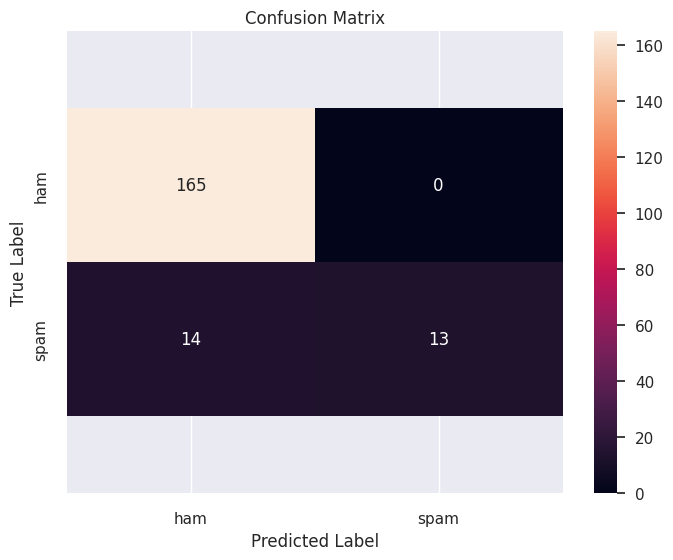

a


In [71]:
! pip install yellowbrick
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train_vect, y_train)
y_pred = rf_model.predict(X_test_vect)
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='Spam', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred)*100, 3)))
sns.set(rc= {"figure.figsize": (8, 6)})
cm = confusion_matrix(y_test, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('a')